# Clustering 3K PBMCs with Adversarial Autoencoders

<img src="adversarial_autoencoder_model.png" width="800px" style="float:center" >

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import os

from utils import plot_results
from AAE3 import *

Using TensorFlow backend.


## Import dataset

In [2]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz -O data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz
!cd data; tar -xzf pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz

mkdir: cannot create directory ‘data’: File exists
--2019-06-13 15:03:36--  http://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_protein_v3/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 143.204.247.106, 143.204.247.13, 143.204.247.31, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|143.204.247.106|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48700600 (46M) [application/x-tar]
Saving to: ‘data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz’

data/pbmc_10k_prote 100%[===================>]  46.44M   308MB/s    in 0.2s    

2019-06-13 15:03:36 (308 MB/s) - ‘data/pbmc_10k_protein_v3_filtered_feature_bc_matrix.tar.gz’ saved [48700600/48700600]



## Data preprocessing

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc10k.h5ad'

scanpy==1.4.3 anndata==0.6.21 umap==0.3.9 numpy==1.15.4 scipy==1.2.0 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [4]:
sc.settings.set_figure_params(dpi=80)

In [5]:
adata = sc.read_10x_mtx(
   './data/filtered_feature_bc_matrix',  # the directory with the `.mtx` file
   var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
   cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_feature_bc_matrix-matrix.h5ad


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

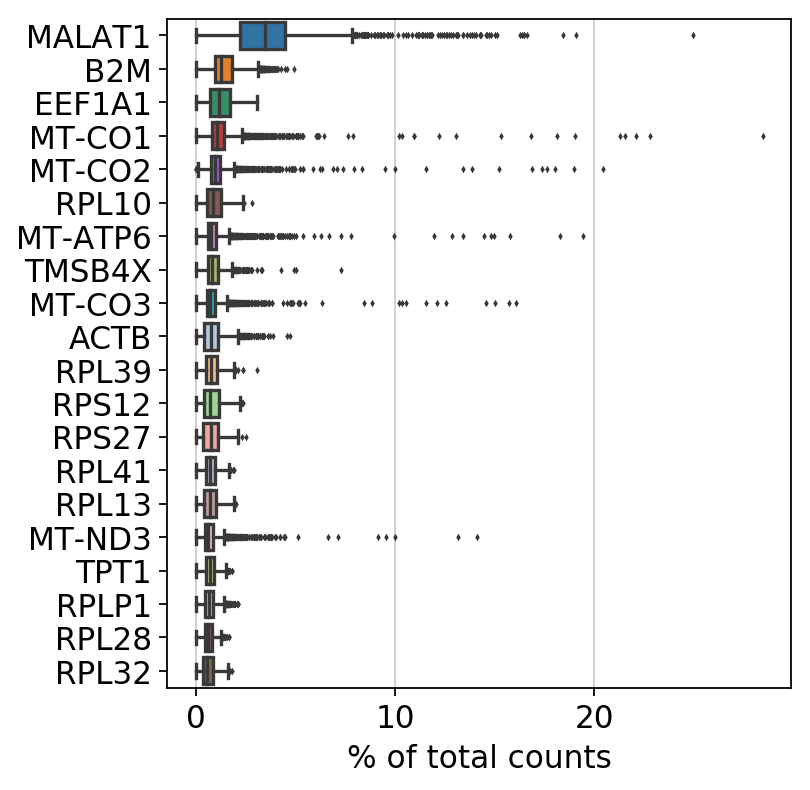

Trying to set attribute `.obs` of view, making a copy.


filtered out 9 cells that have less than 200 genes expressed
filtered out 15484 genes that are detected in less than 3 cells


In [7]:
# Show those genes that yield the highest fraction of counts in each single cells, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20)

# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata = adata[adata.obs['n_genes'] < 2500, :]

In [8]:
# Data in log scale
sc.pp.log1p(adata)

In [9]:
adata.obs.shape

(7173, 1)

In [10]:
adata.obs.head()

n_genes
0                          
AAACCCAAGATTGTGA-1     2194
AAACCCACATCGGTTA-1     2093
AAACCCAGTACCGCGT-1     1518
AAACCCAGTATCGAAA-1      737
AAACCCAGTCGTCATA-1     1240

In [11]:
adata.var.shape

(18054, 3)

In [12]:
adata.var.head()

gene_ids    feature_types  n_cells
AL627309.1  ENSG00000238009  Gene Expression       12
AL669831.5  ENSG00000237491  Gene Expression      446
LINC00115   ENSG00000225880  Gene Expression      180
FAM41C      ENSG00000230368  Gene Expression      298
NOC2L       ENSG00000188976  Gene Expression     1547

In [13]:
adata.var_names

Index(['AL627309.1', 'AL669831.5', 'LINC00115', 'FAM41C', 'NOC2L', 'KLHL17',
       'PLEKHN1', 'AL645608.8', 'HES4', 'ISG15',
       ...
       'MT-CYB', 'BX004987.1', 'MAFIP', 'AC011043.1', 'AL592183.1',
       'AC007325.4', 'AL354822.1', 'AC004556.1', 'AC233755.1', 'AC240274.1'],
      dtype='object', length=18054)

In [14]:
gene_names = adata.var_names.values

In [15]:
data = adata.X.toarray()
#data = normalize(data, axis=-1, order=2)
print(np.any(np.isnan(data)))

False


In [16]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

## Adversarial Autoencoder Model

### Network parameters

In [17]:
original_dim = data.shape[1]

layer_1_dim = 100
layer_2_dim = 50
layer_3_dim = 50
batch_size = 128
latent_dim = 50
epochs = 220

In [18]:
encoder, decoder, discriminator, generator, aae = build_AAE(original_dim, latent_dim, layer_1_dim, layer_2_dim, layer_3_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 18054)        0                                            
__________________________________________________________________________________________________
DO (Dropout)                    (None, 18054)        0           X[0][0]                          
__________________________________________________________________________________________________
H1 (Dense)                      (None, 100)          1805400     DO[0][0]                         
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H1[0][0]                         
____________________________________________________________________________________________

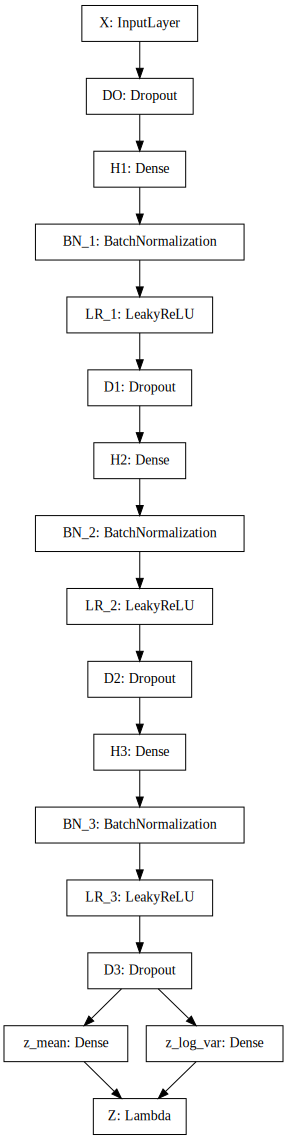

In [19]:
print("\nEncoder Network")
print("===============")
encoder.summary()
os.makedirs('img', exist_ok=True)
plot_model(encoder, to_file='img/aae_encoder.png', show_shapes=True)
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))


Decoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 50)                0         
_________________________________________________________________
DO (Dropout)                 (None, 50)                0         
_________________________________________________________________
H1 (Dense)                   (None, 100)               5000      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 100)               400       
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 100)               0         
_________________________________________________________________
D1 (Dropout)                 (None, 100)               0         
_________________________________________________________________
H2 (Dense)                   (None, 50)                5000

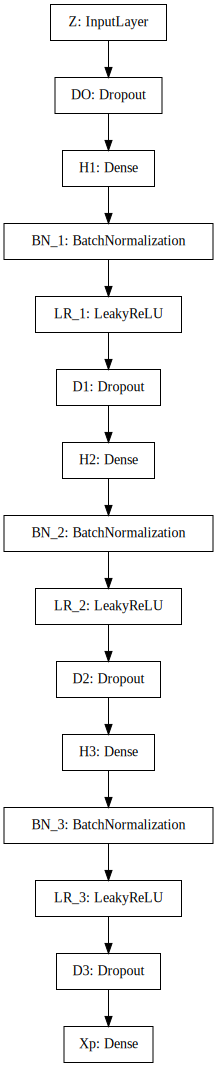

In [20]:
print("\nDecoder Network")
print("===============")
decoder.summary()
plot_model(decoder, to_file='img/aae_decoder.png', show_shapes=True)
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))


Autoencoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 18054)             0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  1818800   
_________________________________________________________________
decoder (Model)              (None, 18054)             934054    
Total params: 2,752,854
Trainable params: 2,752,054
Non-trainable params: 800
_________________________________________________________________


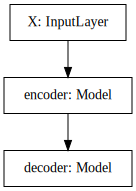

In [21]:
print("\nAutoencoder Network")
print("===================")
aae.summary()
plot_model(aae, to_file='img/aae_autoencoder.png', show_shapes=True)
SVG(model_to_dot(aae).create(prog='dot', format='svg'))


Generator Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 18054)             0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  1818800   
_________________________________________________________________
discriminator (Model)        (None, 1)                 13351     
Total params: 1,832,151
Trainable params: 1,831,351
Non-trainable params: 800
_________________________________________________________________


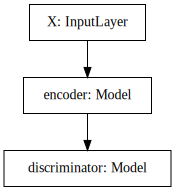

In [22]:
print("\nGenerator Network")
print("===================")
generator.summary()
plot_model(generator, to_file='img/aae_generator.png', show_shapes=True)
SVG(model_to_dot(generator).create(prog='dot', format='svg'))


Discriminator Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 50)                0         
_________________________________________________________________
DO (Dropout)                 (None, 50)                0         
_________________________________________________________________
H1 (Dense)                   (None, 100)               5000      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 100)               400       
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 100)               0         
_________________________________________________________________
D1 (Dropout)                 (None, 100)               0         
_________________________________________________________________
H2 (Dense)                   (None, 50)              

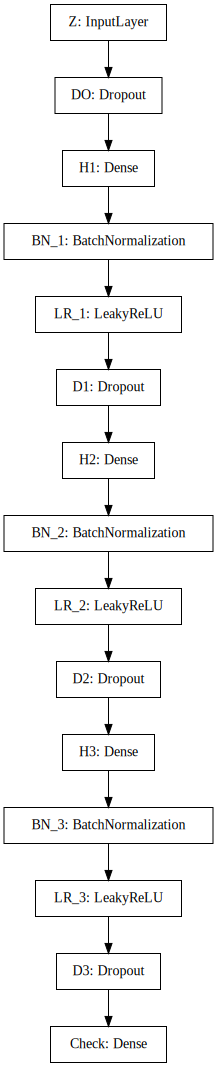

In [23]:
print("\nDiscriminator Network")
print("=====================")
discriminator.summary()
plot_model(discriminator, to_file='img/aae_discriminator.png', show_shapes=True)
SVG(model_to_dot(discriminator).create(prog='dot', format='svg'))

### Model training

Epoch 220/220, reconstruction loss: 1.022215, generation loss: 0.319325, discriminator loss: 0.248735


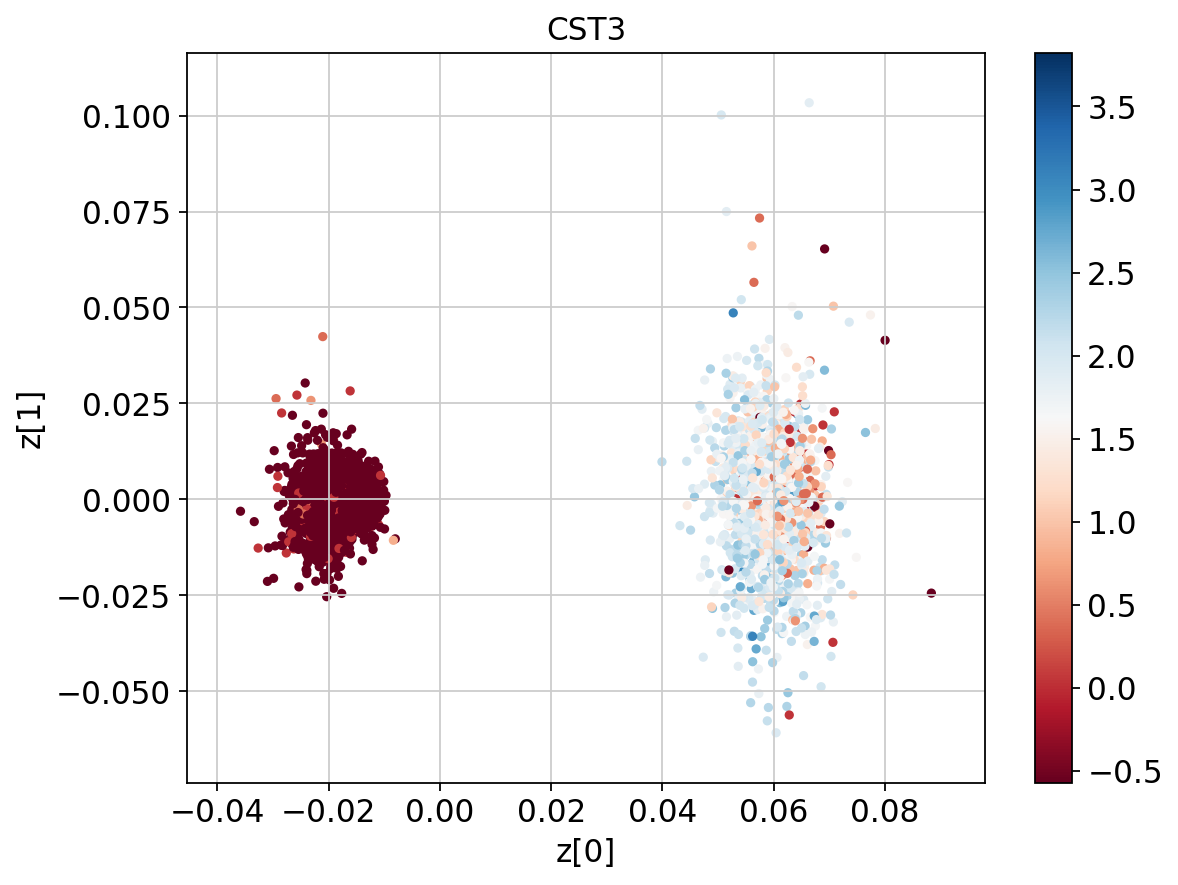

In [24]:
# graph=True to show the data oints in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, disc_loss = train_AAE(aae, generator, discriminator, encoder, decoder,
                                          data, batch_size, latent_dim, epochs, 
                                          gene, gene_names, graph=True, 
                                          val_split=0.0)

# save models
os.makedirs('models', exist_ok=True)
aae.save('models/aae_autoencoder.h5')
generator.save('models/aae_generator.h5')
encoder.save('models/aae_encoder.h5')
decoder.save('models/aae_decoder.h5')
discriminator.save('models/aee_discriminator.h5') 

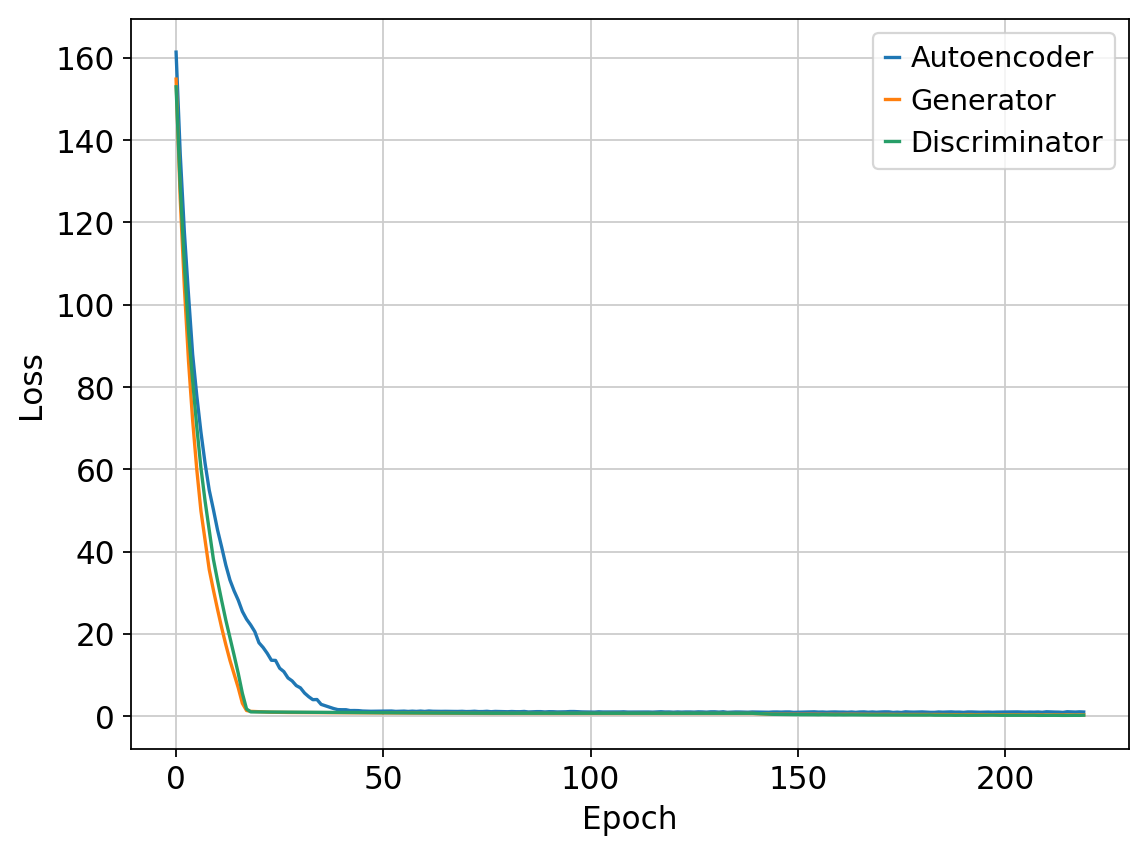

In [25]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([570,700])
#plt.loglog()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

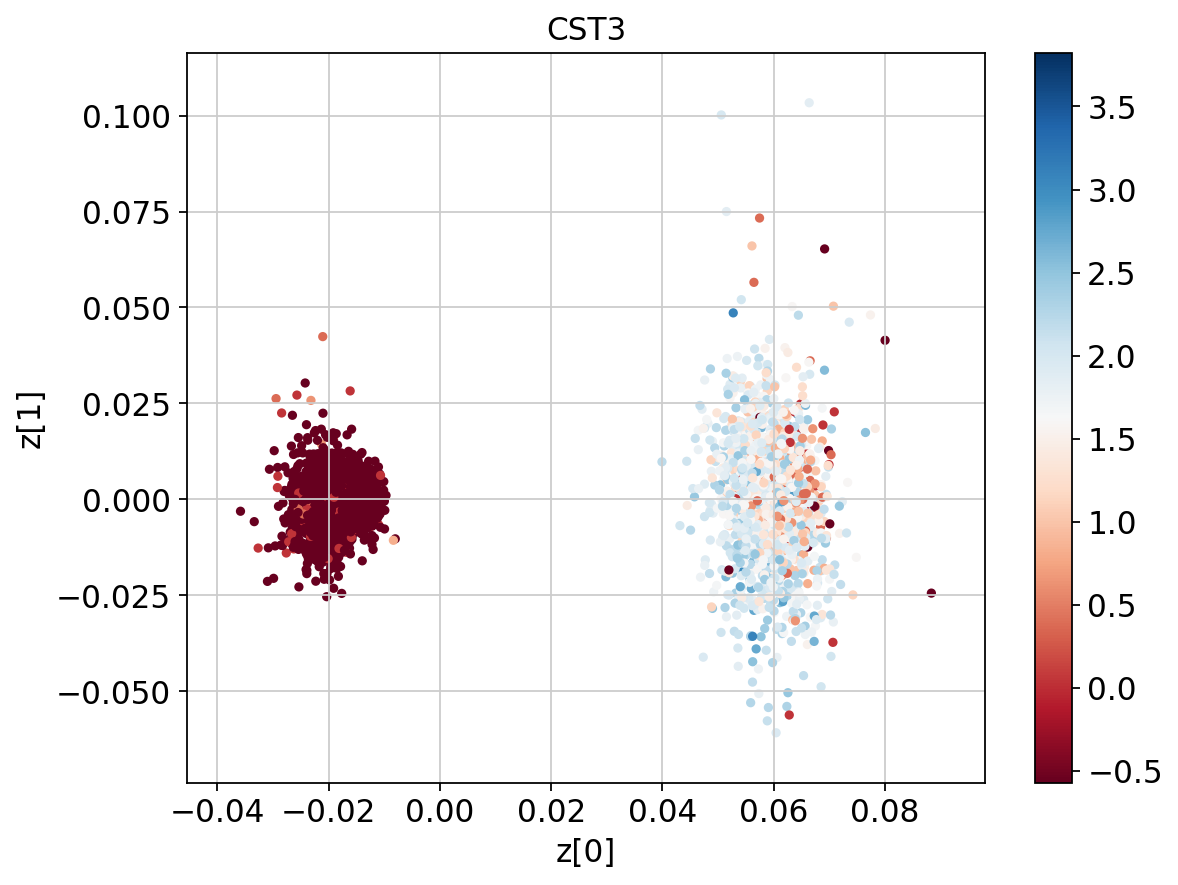

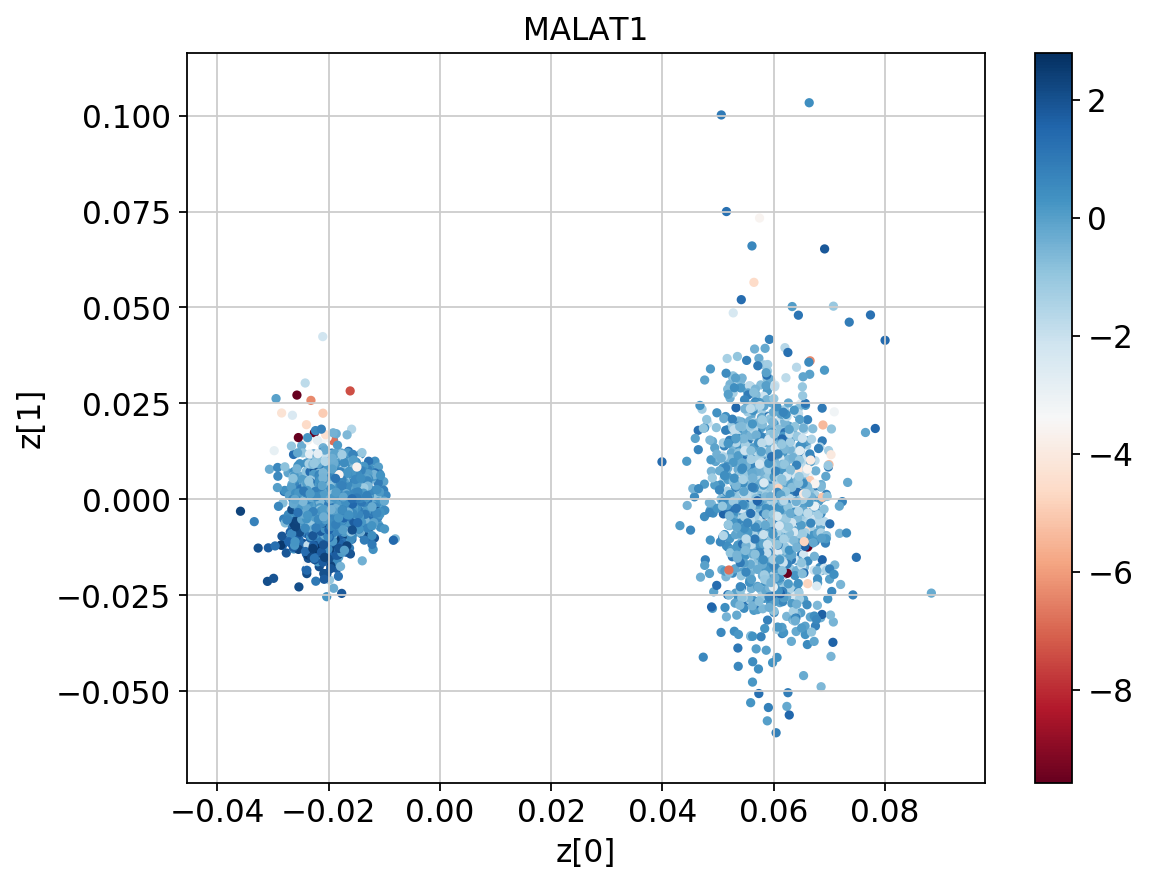

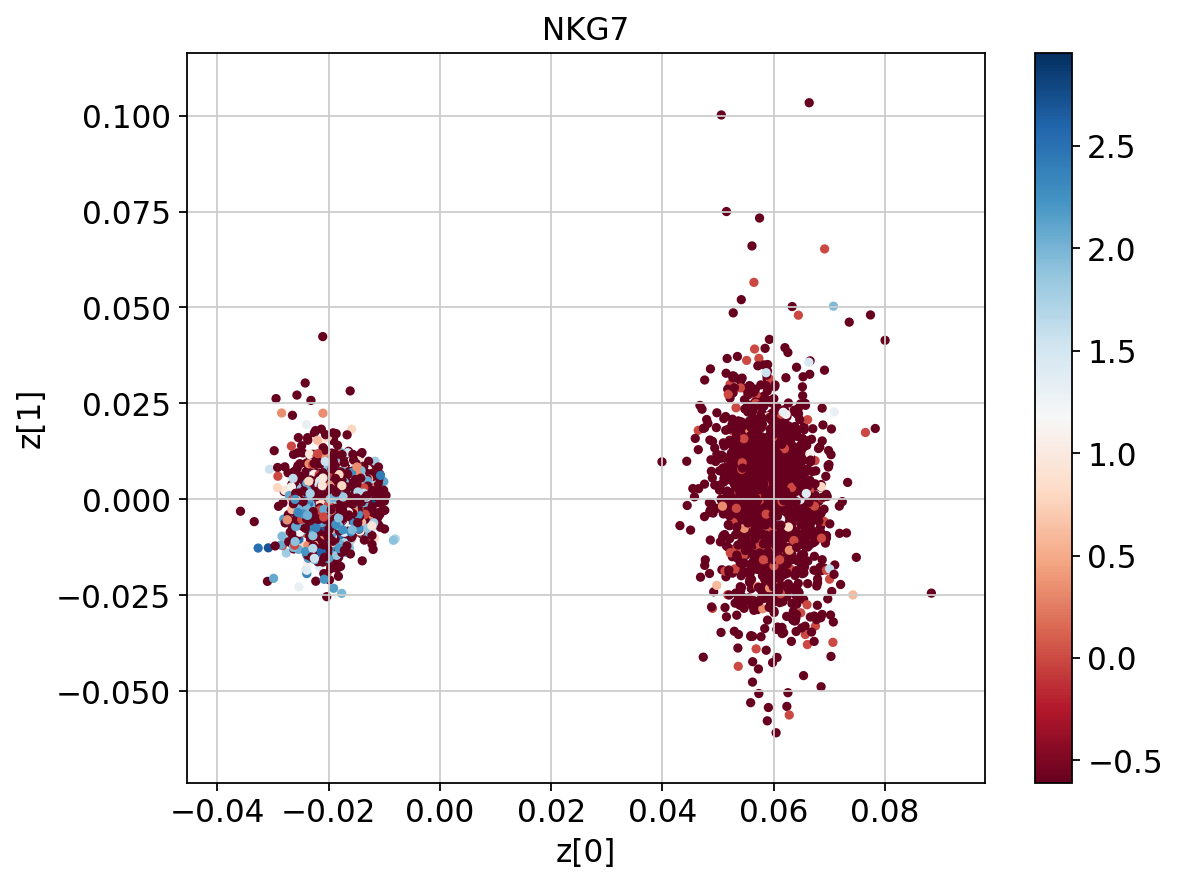

In [26]:
models = (encoder, decoder)
gene_list = ['CST3', 'MALAT1', 'NKG7']
plot_results_pca(models, data, gene_list, gene_names, latent_dim)

pca = PCA(n_components=2500)
pca.fit(data)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')